In [1]:
import numpy as np
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt

### Helper Functions

In [8]:
# Helper functions

# This will balance the prior of preseason rank with the actual win percentage
lower_bound_week = 5
upper_bound_week = 9
def get_team_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week:
        return x[f'Predictive_{home_away}']
        return x[f'Predictive_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week-1))/(upper_bound_week-lower_bound_week+1))) + x[f'rank_winpct_{home_away}'] * ((x['schedule_week']-(lower_bound_week-1))/(upper_bound_week-lower_bound_week+1))
    else:
        return x[f'rank_winpct_{home_away}']

#Similiar function for offensive and defensive rankings
lower_bound_week_offense = 3
upper_bound_week_offense = 7
def get_offensive_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week_offense:
        return x[f'rank_offense_prior_{home_away}']
    elif lower_bound_week_offense <= x['schedule_week'] <= upper_bound_week_offense:
        return x[f'rank_offense_prior_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week_offense-1))/(upper_bound_week_offense-lower_bound_week_offense+1))) + x[f'rank_offense_{home_away}'] * ((x['schedule_week']-(lower_bound_week_offense-1))/(upper_bound_week_offense-lower_bound_week_offense+1))
    else:
        return x[f'rank_offense_{home_away}']    
    
lower_bound_week_defense = 3
upper_bound_week_defense = 7
def get_defensive_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week_defense:
        return x[f'rank_defense_prior_{home_away}']
    elif lower_bound_week_defense <= x['schedule_week'] <= upper_bound_week_defense:
        return x[f'rank_defense_prior_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week_defense-1))/(upper_bound_week_defense-lower_bound_week_defense+1))) + x[f'rank_defense_{home_away}'] * ((x['schedule_week']-(lower_bound_week_defense-1))/(upper_bound_week_defense-lower_bound_week_defense+1))
    else:
        return x[f'rank_defense_{home_away}']    

# Process the AFC/NFC table data from Pro Football Reference and output the processed dataframe
def clean_pfr_tables(input_df, afc_or_nfc):
    
    output_df = input_df.loc[~input_df.Tm.str.contains(afc_or_nfc)]
    output_df.loc[:,'Tm'] = output_df.Tm.str.replace('[^ 0-9a-zA-Z]+', '' ,regex=True)
    return output_df
    
# Run read_html on the specified URL, then extracting both AFC/NFC and concatenating into one dataframe.
def get_weekly_data(my_url):
    week_number = re.findall("(?:week=)(\d+)", my_url)[0]
    year_number = re.findall("(?:year=)(\d+)", my_url)[0]
    tables = pd.read_html(my_url)
    afc = tables[0]
    nfc = tables[1]
    
    cleaned_afc = clean_pfr_tables(afc, "AFC")
    cleaned_nfc = clean_pfr_tables(nfc, "NFC")
    
    combined_week = pd.concat([cleaned_afc, cleaned_nfc])
    
    # The standings are as of the END of the week, so we want to add one to the week to get it to line up with our schedule
    # Added back an actual week column, to use for week 1, when looking to take the prior year data and join with other data
    combined_week.loc[:,'week_number'] = int(week_number) + 1  
    combined_week.loc[:,'actual_week'] = int(week_number)
    combined_week.loc[:,'year_number'] = year_number
    
    combined_week = combined_week.reset_index(drop=True)
    
    return combined_week

# Obtain the presesason rankings data from TeamRankings
def get_preseason_rankings(my_url, year):
    standings_data = pd.read_html(my_url)
    current_year = standings_data[0]
    current_year.loc[:,'season'] = year
    return current_year


### Teams and Scores data from Kaggle

In [40]:
# Provided data from Kaggle, contains the mapping of all iterations of a team name over time

teams = pd.read_csv('../input/nfl-scores-and-betting-data/nfl_teams.csv')

# Remove punctuation from team name
teams.loc[:,'team_name'] = teams['team_name'].str.replace(r'[^\w\s]+', '', regex = True)

# Add Washington Commanders
teams = teams.append(pd.DataFrame({
    "team_name": ['Washington Commanders'],
    "team_name_short": ["Commanders"],
    "team_id": "WAS",
    "team_id_pfr": "WAS",
    "team_conference": "NFC",
    "team_division": "NFC East",
    "team_conference_pre2002": "NFC",
    "team_division_pre2002": "NFC East"
})).reset_index(drop=True)

scores = pd.read_csv('../input/nfl-scores-and-betting-data/spreadspoke_scores.csv')
scores['schedule_week'] = pd.to_numeric(scores.schedule_week, errors = "coerce")
scores = scores.dropna(subset = ['schedule_week'])

# Remove punctuation from home and away team names
scores.loc[:,'team_home'] = scores['team_home'].str.replace(r'[^\w\s]+', '', regex = True)
scores.loc[:,'team_away'] = scores['team_away'].str.replace(r'[^\w\s]+', '', regex = True)


# filter scores data
recent_scores = scores[scores["schedule_season"].isin(list(range(2012, 2022)))]

recent_scores.loc[:,'margin_of_victory'] = abs(recent_scores.loc[:,'score_home'] - recent_scores.loc[:,'score_away'])

recent_scores.loc[:, 'blowout'] = recent_scores.loc[:, 'margin_of_victory'] > 14

# Remove unnecessary columns
recent_scores.drop(['schedule_playoff'], axis = 1, inplace=True)

# Join in the teams data to the scores data (will translate between different team names) 

recent_scores_home_added = pd.merge(recent_scores, teams.add_suffix("_home"), how="left", left_on=["team_home"], right_on = ["team_name_home"])

recent_scores_team_mapping = pd.merge(recent_scores_home_added, teams.add_suffix("_away"), how="left", left_on=["team_away"], right_on = ["team_name_away"])


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Obtain standings data for every week between 2011 and now

In [14]:
# The PFR data does have week 19 for seasons prior to 2021, which would typically comprise playoffs, but they do not update the points, record, or any of the statistics we're pulling here, so it's safe to take that data
weeks = list(range(1,19))
# Grabbing one extra year (2011) to get the end-of-season rank for offense/defense to use at beginning of 2012 season
years = list(range(2011,2022))
df_list = []

for year in years:
    for week in weeks:
        df_list.append(get_weekly_data(f'https://www.pro-football-reference.com/boxscores/standings.cgi?week={week}&year={year}&wk_league=NFL'))
        
standings_data = pd.concat(df_list, axis=0, ignore_index = True)

standings_data.to_csv("./full_standings_data.csv")


In [41]:
# Read already generated standings data

full_standings_data = pd.read_csv("./full_standings_data.csv").drop("Unnamed: 0", axis = 1)

# Join in the teams data for downstream joins
full_standings_data = pd.merge(full_standings_data, teams, how="left", left_on = ["Tm"], right_on = ["team_name"])

# Convert to numerics
full_standings_data[['Pts', 'PtsO', 'W', 'L', 'T', 'year_number', 'week_number']] = full_standings_data[['Pts', 'PtsO', 'W', 'L', 'T', 'year_number', 'week_number']].apply(pd.to_numeric, errors = 'coerce', axis=1)

# in 2011, there were no ties, so PFR data shows the tie column as null, this fills those NAs
full_standings_data[['T']] = full_standings_data[['T']].fillna(0)

# Calculate ppg on offense and defense
full_standings_data['off_ppg'] = full_standings_data.Pts / (full_standings_data['W'] + full_standings_data['L'] + 
                                                                              full_standings_data['T'])
full_standings_data['def_ppg'] = full_standings_data.PtsO / (full_standings_data['W'] + full_standings_data['L'] + 
                                                                              full_standings_data['T'])

# Calculate rankings from ppg data. This will form the basis for some of our engineered features
full_standings_data['rank_offense'] = full_standings_data.groupby(['year_number', 'week_number'])['off_ppg'].rank(method = 'first', ascending = False)
full_standings_data['rank_defense'] = full_standings_data.groupby(['year_number', 'week_number'])['def_ppg'].rank(method = 'first', ascending = True)

# Calculate overall ranking from win percentage, again forming basis for our feature engineering
full_standings_data['rank_winpct'] = full_standings_data.groupby(['year_number', 'week_number'])['W-L%'].rank(method = 'first', ascending = False)


In [42]:
# Take the last week of data for each year, set as the prior season's rankings (we added one to the week, so week 19 corresponds to 18)
prior_season_ending_rankings = full_standings_data[full_standings_data.week_number == 19]

# Drop all unnecessary columns (all but the team name, ID, and offense/defense rankings)
prior_season_ending_rankings.drop(['W', 'L', 'W-L%', 'Pts', 'PtsO', 'PtDif', 'MoV', 'week_number', 
                                   'T', 'off_ppg', 'def_ppg', 'rank_winpct', 'team_name', 
                                  'team_name_short', 'team_conference', 'team_division', 
                                  'team_conference_pre2002', 'team_division_pre2002'],
                                  axis=1, inplace=True)


# Merge does not allow for non-equijoins, so we join every team against itself
current_and_prior = pd.merge(full_standings_data, prior_season_ending_rankings.add_suffix("_prior"), 
                                how = "left", left_on = ['team_id'], 
                                right_on=['team_id_prior'])

# Then cut down to only where the prior year is one behind the current here
current_and_prior = current_and_prior[(current_and_prior['year_number_prior']==current_and_prior['year_number'] - 1)]

current_and_prior.to_csv("current_and_prior_year_standings.csv")

Below is the code used to obtain preseason ratings data for every year between 2012 and now

In [43]:

preseason_rankings_list = []
years = list(range(2012,2022))

# Getting the rankings as of September 5th of each year, which is effectively the preseason ranking as Week 1 has never started this early but it's close to the beginning of the year. Except 2011, 2016, 2018.
for year in years:
    if year == 2011:
        preseason_rankings_list.append(get_preseason_rankings(my_url = "https://www.teamrankings.com/nfl/rankings/teams/?date=2011-09-07", year = year))
    elif year == 2016:
        preseason_rankings_list.append(get_preseason_rankings(my_url = "https://www.teamrankings.com/nfl/rankings/teams/?date=2016-09-07", year = year))
    elif year == 2018:
        preseason_rankings_list.append(get_preseason_rankings(my_url = "https://www.teamrankings.com/nfl/rankings/teams/?date=2018-09-05", year = year))
    else:
        preseason_rankings_list.append(get_preseason_rankings(my_url = f"https://www.teamrankings.com/nfl/rankings/teams/?date={year}-09-03", year = year))
    
preseason_rankings = pd.concat(preseason_rankings_list, axis=0, ignore_index = True)

preseason_rankings_df = pd.merge(preseason_rankings, teams[['team_id', 'team_name']], how="left", left_on = ['Team'], right_on = ['team_name']).drop(['team_name'], axis=1)

# Dropping these columns as we're only looking for preseason rank here
preseason_rankings_df.drop(['Home', 'Away', 'Last 5', 'In Div.', 'SOS'], axis = 1, inplace = True)

preseason_rankings_df.to_csv("./preseason_rankings_df.csv")

In [18]:
list(range(2012,2022))

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [ ]:
# Read already generated preseason_ratings data

#preseason_rankings_df = pd.read_csv("./preseason_rankings_df.csv")

In [44]:
# Join Scores data to Standings data, first on the home team to get standings of the home team as of kickoff
scores_and_standings = pd.merge(recent_scores_team_mapping, 
                                current_and_prior[['Tm', 'W', 'L', 'T', 'Pts', 'PtsO', 'week_number',
                                                   'year_number', 'off_ppg', 'def_ppg', 'rank_offense',
                                                   'rank_defense', 'rank_winpct', 'team_id'#,
                                                   #'Tm_prior','year_number_prior', 'team_id_prior', 'team_id_pfr_prior', 'rank_offense_prior', 'rank_defense_prior'
                                                  ]].add_suffix("_home"), 
                                how = "left", left_on = ['schedule_season', 'schedule_week', 'team_id_home'], 
                                right_on=['year_number_home', 'week_number_home', 'team_id_home'])

# Next join on the away team
scores_and_standings_all = pd.merge(scores_and_standings, 
                                current_and_prior[['Tm', 'W', 'L', 'T', 'Pts', 'PtsO', 'week_number',
                                                   'year_number', 'off_ppg', 'def_ppg', 'rank_offense',
                                                   'rank_defense', 'rank_winpct', 'team_id'#,
                                                   #'Tm_prior','year_number_prior', 'team_id_prior', 'team_id_pfr_prior', 'rank_offense_prior', 'rank_defense_prior'
                                                  ]].add_suffix("_away"), 
                                how = "left", left_on = ['schedule_season', 'schedule_week', 'team_id_away'], 
                                right_on=['year_number_away', 'week_number_away', 'team_id_away'])

# For all week 1 games, the standings data with be NAN, because there are no standings at that point. Need to replace these with 0 to allow for EDA and other processing
scores_and_standings_all[['W_home', 'L_home', 'T_home', 'Pts_home', 'PtsO_home', 'week_number_home', 'year_number_home', 'off_ppg_home', 
                          'def_ppg_home', 'rank_offense_home','rank_defense_home', 'rank_winpct_home', 'W_away', 'L_away', 'T_away', 
                          'Pts_away', 'PtsO_away', 'week_number_away', 'year_number_away', 'off_ppg_away', 'def_ppg_away', 'rank_offense_away',
                          'rank_defense_away', 'rank_winpct_away']] = scores_and_standings_all[['W_home', 'L_home', 'T_home', 'Pts_home', 'PtsO_home', 'week_number_home', 'year_number_home', 'off_ppg_home', 
                          'def_ppg_home', 'rank_offense_home','rank_defense_home', 'rank_winpct_home', 'W_away', 'L_away', 'T_away', 
                          'Pts_away', 'PtsO_away', 'week_number_away', 'year_number_away', 'off_ppg_away', 'def_ppg_away', 'rank_offense_away',
                          'rank_defense_away', 'rank_winpct_away']].fillna(0)

# Get rid of unnecessary columns
scores_and_standings_all.drop(['Tm_home', 'Tm_away', 'year_number_home', 'week_number_home', 'year_number_away', 'week_number_away'], axis=1, inplace=True)


# Join back to current_and_prior on actual_week to get prior year data
scores_and_standings_all = pd.merge(scores_and_standings_all, 
                                   current_and_prior[['team_id', 'year_number', 'actual_week', 'rank_offense_prior', 'rank_defense_prior']].add_suffix("_home"),
                                   how = "left", left_on = ['schedule_season', 'team_id_home', 'schedule_week'],
                                   right_on = ['year_number_home', 'team_id_home', 'actual_week_home'])

scores_and_standings_all = pd.merge(scores_and_standings_all, 
                                   current_and_prior[['team_id', 'year_number', 'actual_week', 'rank_offense_prior', 'rank_defense_prior']].add_suffix("_away"),
                                   how = "left", left_on = ['schedule_season', 'team_id_away', 'schedule_week'],
                                   right_on = ['year_number_away', 'team_id_away', 'actual_week_away'])


In [45]:
# Next, join in the rankings data for the home team, giving us a preseason rank 
scores_and_rankings = pd.merge(scores_and_standings_all, preseason_rankings_df.add_suffix("_home"), 
                                how = "left", left_on = ['schedule_season', 'team_id_home'], 
                                right_on=['season_home', 'team_id_home'])

# Then get the away team's preseason rank
scores_and_rankings_all = pd.merge(scores_and_rankings, preseason_rankings_df.add_suffix("_away"), 
                                how = "left", left_on = ['schedule_season', 'team_id_away'], 
                                right_on=['season_away', 'team_id_away'])

# Drop unnecessary columns
scores_and_rankings_all.drop(['season_home', 'Team_home', 'season_away', 'Team_away'], axis = 1, inplace=True)


In [46]:
# assumptions
bad_team_rank = 25
good_offense_rank = 8
good_defense_rank = 8
lopsided_threshold = 12

# feature engineering

# Is the team bad? 
scores_and_rankings_all.loc[:,'team_home_ranking'] = scores_and_rankings_all.apply(lambda x: get_team_ranking(x, 'home'), axis = 1)
scores_and_rankings_all.loc[:,'team_away_ranking'] = scores_and_rankings_all.apply(lambda x: get_team_ranking(x, 'away'), axis = 1)
scores_and_rankings_all.loc[:,'bad_team_involved'] = scores_and_rankings_all.apply(lambda x: True if x['team_away_ranking'] >= bad_team_rank or x['team_home_ranking'] >= bad_team_rank else False, axis = 1)

# Blend prior season offense/defense rankings with current season (in the early part of the season)
scores_and_rankings_all.loc[:, 'final_rank_offense_home'] = scores_and_rankings_all.apply(lambda x: get_offensive_ranking(x, 'home'), axis = 1)
scores_and_rankings_all.loc[:, 'final_rank_offense_away'] = scores_and_rankings_all.apply(lambda x: get_offensive_ranking(x, 'away'), axis = 1)
scores_and_rankings_all.loc[:, 'final_rank_defense_home'] = scores_and_rankings_all.apply(lambda x: get_defensive_ranking(x, 'home'), axis = 1)
scores_and_rankings_all.loc[:, 'final_rank_defense_away'] = scores_and_rankings_all.apply(lambda x: get_defensive_ranking(x, 'away'), axis = 1)

# Singular high-powered offense (if both are high, False. If one is high and defense is elite, False)
#scores_and_rankings_all.loc[:, 'high_powered_offense'] = scores_and_rankings_all.apply(lambda x: True if (x['rank_offense_home'] <= good_offense_rank and x['rank_offense_away'] > good_offense_rank and x['rank_defense_away'] > good_defense_rank) or (x['rank_offense_away'] <= good_offense_rank and x['rank_offense_home'] > good_offense_rank and x['rank_defense_home'] > good_defense_rank) else False, axis = 1)
scores_and_rankings_all.loc[:, 'high_powered_offense'] = scores_and_rankings_all.apply(lambda x: True if (x['final_rank_offense_home'] <= good_offense_rank and x['final_rank_offense_away'] > good_offense_rank and x['final_rank_defense_away'] > good_defense_rank) or (x['final_rank_offense_away'] <= good_offense_rank and x['final_rank_offense_home'] > good_offense_rank and x['final_rank_defense_home'] > good_defense_rank) else False, axis = 1)

# Lopsided matchup?
scores_and_rankings_all.loc[:, 'lopsided_matchup'] = scores_and_rankings_all.apply(lambda x: True if abs(x['team_home_ranking'] - x['team_away_ranking']) >= lopsided_threshold else False, axis = 1)

# bet?
scores_and_rankings_all.loc[:, 'bet_the_game'] = scores_and_rankings_all.apply(lambda x: True if x['bad_team_involved'] == False and x['high_powered_offense'] == False and x['lopsided_matchup'] == False else False, axis = 1)

# Did we win the bet?
scores_and_rankings_all.loc[:, 'win_bet'] = scores_and_rankings_all.apply(lambda x: True if x['bet_the_game'] == True and x['blowout'] == False else False, axis = 1)
scores_and_rankings_all[scores_and_rankings_all['bet_the_game'] == True].win_bet.value_counts(normalize=True)

True     0.733742
False    0.266258
Name: win_bet, dtype: float64

In [47]:
# Drop columns from final analytical dataset that are superfluous
final_dataset = scores_and_rankings_all.drop(['team_name_home', 'team_name_short_home', 'team_id_pfr_home', 'team_conference_pre2002_home', 'team_division_pre2002_home',
                                             'team_name_away', 'team_name_short_away', 'team_id_pfr_away', 'team_conference_pre2002_away', 'team_division_pre2002_away',
                                             'year_number_home', 'year_number_away', 'actual_week_home', 'actual_week_away'], axis = 1)

final_dataset.to_csv("./third_pass_output.csv")

<AxesSubplot:>

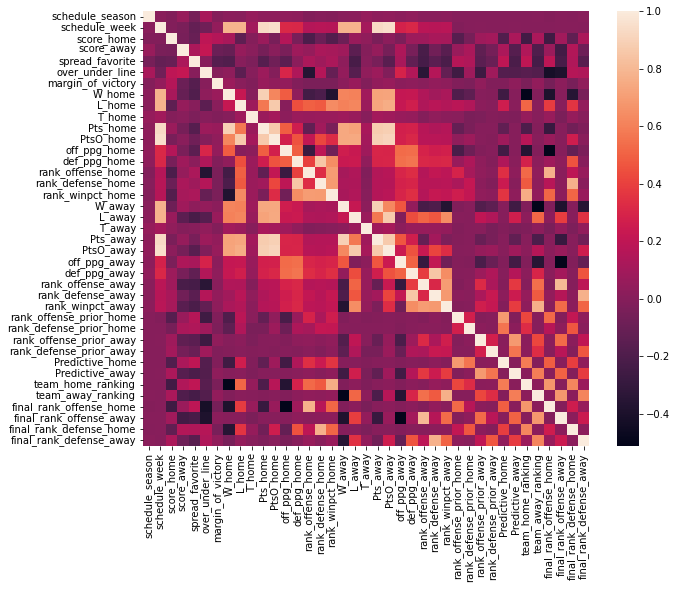

In [48]:
# Exploratory Analysis

# Removing weather data, will revisit with time
eda_dataset = pd.read_csv('./third_pass_output.csv').drop(['Unnamed: 0', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'weather_detail'], axis = 1)

eda_dataset[['W_home', 'off_ppg_away']] = eda_dataset[['W_home', 'off_ppg_away']].fillna(0)
numeric_data = eda_dataset.select_dtypes(include=[np.number])
plt.figure(figsize = (10,8))
sns.heatmap(numeric_data.corr())

<AxesSubplot:xlabel='weather_humidity', ylabel='margin_of_victory'>

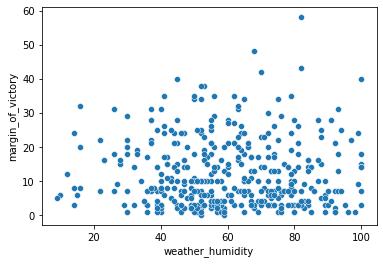

In [28]:
sns.scatterplot(x='weather_humidity', y='margin_of_victory', data=final_dataset)

In [49]:
numeric_data.isna().sum().sort_values()

schedule_season            0
PtsO_away                  0
off_ppg_away               0
def_ppg_away               0
rank_offense_away          0
rank_defense_away          0
rank_winpct_away           0
rank_offense_prior_home    0
Pts_away                   0
rank_defense_prior_home    0
rank_defense_prior_away    0
Predictive_home            0
Predictive_away            0
team_home_ranking          0
team_away_ranking          0
final_rank_offense_home    0
final_rank_offense_away    0
rank_offense_prior_away    0
final_rank_defense_home    0
T_away                     0
W_away                     0
schedule_week              0
score_home                 0
score_away                 0
spread_favorite            0
over_under_line            0
margin_of_victory          0
W_home                     0
L_away                     0
L_home                     0
Pts_home                   0
PtsO_home                  0
off_ppg_home               0
def_ppg_home               0
rank_offense_h

In [26]:
# Trying unsupervised methods to group games and look at mix of blowouts/non-blowouts

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

X = numeric_data.drop('margin_of_victory', axis = 1)
y = numeric_data['margin_of_victory']

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size = 0.3)
my_kmeans = KMeans()
my_kmeans.fit(X_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# TODO
# Add player data
# Consider the threshold games...difference between 14 and 15 is win/loss
# Think about how to incorporate lines...the underdogs winning by 14+ is a winning bet
# Missing TeamRankings data for multiple seasons
# Run tree model on margin of victory to get initial sense of predictive power of various variables
# Look for multicollinearity/opportunities to get rid of correlated variables